In [ ]:
!pip install pandas numpy matplotlib seaborn networkx scikit-learn

In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
df = pd.read_csv('lol_ranked_games.csv')
print(df.info())

In [ ]:
print("Total rows:", df.shape[0])
print("Total columns:", df.shape[1])
df.tail(10)

In [ ]:
print("Missing Data: \n", df.isnull().sum())

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
print(df.describe(include='all'))

In [ ]:
df.hist(bins=30, figsize=(20, 20))
plt.show()

In [ ]:
selected_columns = ['goldDiff', 'expDiff', 'kills', 'deaths', 'assists']
sns.pairplot(df[selected_columns])
plt.show()

In [ ]:
plt.figure(figsize=(40, 35))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

In [ ]:
winning_correlation = df.corr()['hasWon'].to_frame().T
plt.subplots(figsize=(20, 2))
sns.heatmap(winning_correlation)
plt.show()

In [ ]:
df_f10 = df[df['frame'] == 10]
winning_correlation = df_f10.corr()['hasWon'].to_frame().T
plt.subplots(figsize=(20, 2))
sns.heatmap(winning_correlation)
plt.show()

In [ ]:
high_impact_columns = ['goldDiff', 'expDiff', 'champLevelDiff', 'kills', 'deaths', 'assists', 'isFirstTower', 'isFirstBlood']
df_high_impact = df[high_impact_columns]
print(df_high_impact.tail(10))

In [ ]:
#DATA SETUP

# Filter for frame=10
df_frame_10 = df[df['frame'] == 10].copy()

# Create derived columns
df_frame_10['kda'] = df_frame_10['kills'] + (df_frame_10['assists'] // 2) - df_frame_10['deaths']
df_frame_10['wardsDiff'] = df_frame_10['wardsPlaced'] - df_frame_10['wardsLost']

drake_columns_killed = ['killedFireDrake', 'killedWaterDrake', 'killedAirDrake', 'killedEarthDrake']
drake_columns_lost = ['lostFireDrake', 'lostWaterDrake', 'lostAirDrake', 'lostEarthDrake']
df_frame_10['drakeDiff'] = df[drake_columns_killed].sum(axis=1) - df[drake_columns_lost].sum(axis=1)

turrets_destroyed = ['destroyedTopOuterTurret', 'destroyedMidOuterTurret', 'destroyedBotOuterTurret']
turret_lost = ['lostTopOuterTurret', 'lostMidOuterTurret', 'lostBotOuterTurret']
df_frame_10['laneProgression'] = df[turrets_destroyed].sum(axis=1) - df[turret_lost].sum(axis=1)

# Discretize data
df_frame_10['goldDiff'] = (df_frame_10['goldDiff'] > 0).astype(int)
df_frame_10['expDiff'] = (df_frame_10['expDiff'] > 0).astype(int)
df_frame_10['wardsDiff'] = (df_frame_10['wardsDiff'] > 0).astype(int)
df_frame_10['drakeDiff'] = (df_frame_10['drakeDiff'] > 0).astype(int)
df_frame_10['kda'] = (df_frame_10['kda'] > 1).astype(int)
df_frame_10['killedRiftHerald'] = (df_frame_10['killedRiftHerald'] > 0).astype(int)
df_frame_10['laneProgression'] = (df_frame_10['laneProgression'] > 0).astype(int)

# Select relevant columns
df_bn = df_frame_10[['hasWon', 'goldDiff', 'expDiff', 'kda', 'wardsDiff', 'isFirstBlood', 'isFirstTower',
                     'killedRiftHerald', 'drakeDiff', 'laneProgression']]
print(df_bn.head(20))

# Define Bayesian network edges manually based on provided design with separate goldDiff and expDiff
edges = [
    ('kda', 'goldDiff'),
    ('kda', 'expDiff'),
    ('isFirstBlood', 'kda'),
    ('drakeDiff', 'kda'),
    ('wardsDiff', 'drakeDiff'),
    ('wardsDiff', 'isFirstBlood'),
    ('wardsDiff', 'kda'),
    ('isFirstTower', 'laneProgression'),
    ('laneProgression', 'hasWon'),
    ('killedRiftHerald', 'laneProgression'),
    ('killedRiftHerald', 'isFirstTower'),
    ('drakeDiff', 'kda'),
    ('isFirstTower', 'kda'),
    ('goldDiff', 'hasWon'),
    ('expDiff', 'hasWon')
]

# Visualize the network
plt.figure(figsize=(12, 8))
G = nx.DiGraph(edges)
nx.draw(G, with_labels=True, node_size=3000, node_color='lightblue', font_size=15, font_weight='bold')
plt.title('Bayesian Network for LoL Data with Separate goldDiff and expDiff Nodes')
plt.show()

In [189]:
#DATA SPLITTING AND CPTS
target = 'hasWon'
train_data, test_data = train_test_split(df_bn, test_size=0.25, random_state=42)
print(f"Training Set Size: {len(train_data)}, Testing Set Size: {len(test_data)}")

# Calculating CPTs using Maximum Likelihood Estimation(MLE)
P_hasWon_given_gd_ed_lp = train_data.groupby(['goldDiff', 'expDiff', 'laneProgression'])['hasWon'].value_counts(normalize=True).unstack().fillna(0)
P_lp_given_ft_rh = train_data.groupby(['isFirstTower', 'killedRiftHerald'])['laneProgression'].value_counts(normalize=True).unstack().fillna(0)
P_gd_given_k = train_data.groupby('kda')['goldDiff'].value_counts(normalize=True).unstack().fillna(0)
P_ed_given_k = train_data.groupby('kda')['expDiff'].value_counts(normalize=True).unstack().fillna(0)
P_k_given_fb_dd_wd_ft = train_data.groupby(['isFirstBlood', 'drakeDiff', 'wardsDiff', 'isFirstTower'])['kda'].value_counts(normalize=True).unstack().fillna(0)
P_dd_given_wd = train_data.groupby('wardsDiff')['drakeDiff'].value_counts(normalize=True).unstack().fillna(0)
P_fb_given_wd = train_data.groupby('wardsDiff')['isFirstBlood'].value_counts(normalize=True).unstack().fillna(0)
P_ft_given_rh = train_data.groupby('killedRiftHerald')['isFirstTower'].value_counts(normalize=True).unstack().fillna(0)

# Compute marginal probabilities for nodes without parents
P_wd = train_data['wardsDiff'].value_counts(normalize=True).to_dict()
P_rh = train_data['killedRiftHerald'].value_counts(normalize=True).to_dict()

# DATA VISUALIZING
display(P_hasWon_given_gd_ed_lp)
display(P_lp_given_ft_rh)
display(P_ed_given_k)
display(P_k_given_fb_dd_wd_ft)
display(P_dd_given_wd)
display(P_fb_given_wd)
display(P_ft_given_rh)
display(P_wd)
display(P_rh)

Training Set Size: 18684, Testing Set Size: 6228


hasWon                                   0         1
goldDiff expDiff laneProgression                    
0        0       0                0.752527  0.247473
                 1                0.896552  0.103448
         1       0                0.518600  0.481400
                 1                0.333333  0.666667
1        0       0                0.456423  0.543577
                 1                0.391304  0.608696
         1       0                0.253941  0.746059
                 1                0.122549  0.877451

laneProgression                       0         1
isFirstTower killedRiftHerald                    
0            0                 1.000000  0.000000
             1                 1.000000  0.000000
1            0                 0.047826  0.952174
             1                 0.043137  0.956863

expDiff,0,1
kda,,
0,0.817621,0.182379
1,0.271906,0.728094


kda                                                   0         1
isFirstBlood drakeDiff wardsDiff isFirstTower                    
0            0         1         0             1.000000  0.000000
                                 1             1.000000  0.000000
             1         1         0             1.000000  0.000000
1            0         1         0             0.511409  0.488591
                                 1             0.201754  0.798246
             1         1         0             0.291497  0.708503
                                 1             0.082031  0.917969

drakeDiff,0,1
wardsDiff,,
1,0.616089,0.383911


isFirstBlood,0,1
wardsDiff,,
1,0.00942,0.99058


isFirstTower,0,1
killedRiftHerald,,
0,0.985814,0.014186
1,0.896803,0.103197


{1: 1.0}

{0: 0.8677478056090773, 1: 0.13225219439092273}

In [191]:
# Training our data
def predict_win_probability(evidence):
    """
    Computes P(hasWon | evidence) using the trained Bayesian Network.
    """
    try:
        # Extract evidence values
        gd, ed, lp = evidence['goldDiff'], evidence['expDiff'], evidence['laneProgression']

        # Compute probability of winning and losing
        P_win = P_hasWon_given_gd_ed_lp.loc[gd, ed, lp].get(1, 1e-6)  # P(hasWon=1 | gd, ed, lp)
        P_lose = P_hasWon_given_gd_ed_lp.loc[gd, ed, lp].get(0, 1e-6)  # P(hasWon=0 | gd, ed, lp)

        # Normalize probabilities
        total = P_win + P_lose
        P_win /= total
        P_lose /= total

        return 1 if P_win > P_lose else 0  # Return predicted class
    
    except KeyError as e:
        print(f"Missing key: {e}, using default probability")
        return np.random.choice([0, 1])  # Randomly assign if missing values

Model Accuracy: 0.7110


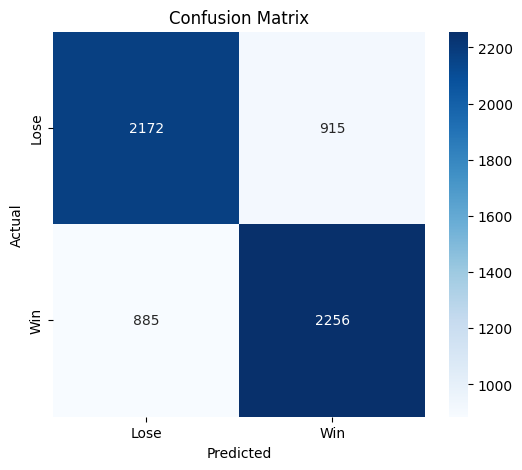

In [192]:
# DATA TESTING AND EVALUATING

# Testing data
test_data['predicted_hasWon'] = test_data.apply(lambda row: predict_win_probability(row), axis=1)

# Compute accuracy
accuracy = (test_data['hasWon'] == test_data['predicted_hasWon']).mean()
print(f"Model Accuracy: {accuracy:.4f}")

# Compute confusion matrix
cm = confusion_matrix(test_data['hasWon'], test_data['predicted_hasWon'])

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Lose", "Win"], yticklabels=["Lose", "Win"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()